# Bias quantification in word2vec models trained on plain language corpora

The models used here are from [Fauconnier](https://fauconnier.github.io/).

In [1]:
# loading libraries 
import gensim
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import seaborn as sns
import pandas as pd
import copy

# increase plots resolution 
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

# import internal libraries 
import os 
os.chdir("../lib/")
from utils import *
os.chdir("../notebooks/")

In [2]:
# loading word2vec pre-trained word2vec
cbow_200 = KeyedVectors.load_word2vec_format("../../new_pretrained_word2vec/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin", binary=True, unicode_errors="ignore")
sg_200 = KeyedVectors.load_word2vec_format("../../new_pretrained_word2vec/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin", binary=True, unicode_errors="ignore")
sg_500 = KeyedVectors.load_word2vec_format("../../new_pretrained_word2vec/frWac_non_lem_no_postag_no_phrase_500_skip_cut100.bin", binary=True, unicode_errors="ignore")

### Identifying the grammatical gender direction 


Before performing any bias measurements, we should first disentangle the grammatical gender direction.
For this, we use the iterative method proposed by [Sabbaghi et al.](https://arxiv.org/pdf/2206.01691.pdf). It consists of iteratively extracting the grammatical gender direction from the new word embedding (from which the grammatical component is removed) until we reach an classification accuracy $^{\star}$ of $\approx 50\%$. The iteratively extracted grammatical gender directions are saved to be used later in removing the grammatical gender component from word embeddings. 

$^{\star}$ The classification task consist of using LDA to distinguish between grammatically feminine and grammatically masculine words.

In [16]:
# load grammatical gender word lists
with open("../data/grammatical_masculine_final_used.txt", "r") as output:
#with open("../data/grammatical_masculine.txt", "r") as output:
    masc_gram = output.read()
    output.close()

with open("../data/grammatical_feminine_final_used.txt", "r") as output:
#with open("../data/grammatical_feminine.txt", "r") as output:    
    fem_gram = output.read()
    output.close()

fem_gram = fem_gram.split('\n')
masc_gram = masc_gram.split('\n')

# final lists of words that appear in the vocab of all models
final_gram_fem, final_gram_masc = [], []
for word in fem_gram:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        final_gram_fem.append(word)

for word in masc_gram:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        final_gram_masc.append(word)

print(len(final_gram_fem), len(final_gram_masc))

896 894


In [17]:
# keep the same size for both lists
n_words = min(len(final_gram_fem), len(final_gram_masc))
final_gram_fem, final_gram_masc = final_gram_fem[:n_words], final_gram_masc[:n_words]
print(len(final_gram_fem), len(final_gram_masc))

894 894


`gram_dirct` function from `lib/utils.py` returns the iterative grammatical gender directions as well as the classification test scores that reflect how much more grammatical signals are still hidden in the word embeddings. 

The retrieved grammatical gender directions will later be used to disentangle the grammatical signals from embeddings. 

In [18]:
test_scores_cbow_200, gram_drcts_cbow_200 = gram_dirct(cbow_200, final_gram_fem, final_gram_masc)
test_scores_sg_200, gram_drcts_sg_200 = gram_dirct(sg_200, final_gram_fem, final_gram_masc)
test_scores_sg_500, gram_drcts_sg_500 = gram_dirct(sg_500, final_gram_fem, final_gram_masc)

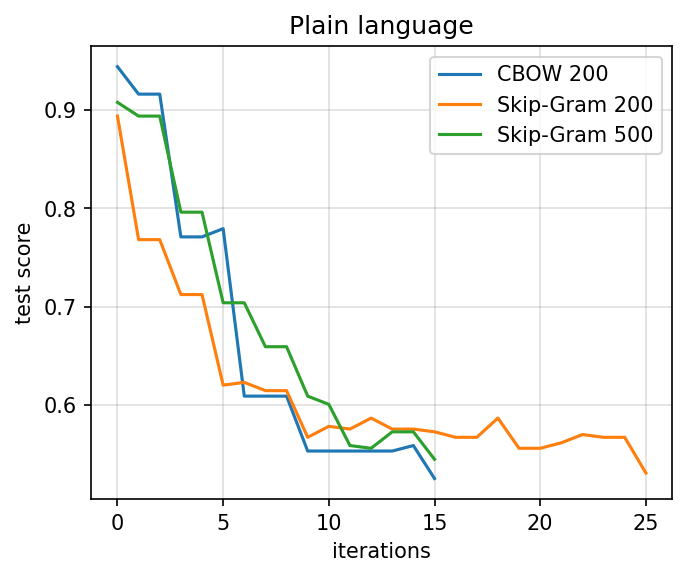

In [19]:
# plot of the test scores 
plt.figure(figsize=(5,4))
plt.plot(test_scores_cbow_200, label='CBOW 200')
plt.plot(test_scores_sg_200, label='Skip-Gram 200')
plt.plot(test_scores_sg_500, label='Skip-Gram 500')
#plt.title("Grammatical gender classification test scores")
plt.title("Plain language")
plt.xlabel("iterations")
plt.ylabel("test score")
plt.grid(color='gray', linestyle='-', linewidth=.2)
plt.legend()
#plt.savefig("../figures/grammatical_disen_plain", dpi=300)
plt.show()

### Permutation statistical test

In this section, we present the framework of the permutation test statistic we will use to evaluate how some lists of words are more biased towards men or women. 

First off, we denote by:
* **A**: 1st attributes list: **men-definition words** {fils, père, frère, pères, monsieur, homme, masculin}
* **B**: 2nd attributes list: **women-definition words** {fille, mère, sœur, mères, madame, femme, féminin}

* **X**: 1st target words: e.g. **science**
* **Y**: 2nd target words: e.g. **arts**

*Note:* 
* During this test statistic, we will always make sure to have X and Y denote the lists of topic words that are likely to reflect the bias in the corpus. For instance, by taking *X=science* and *Y=arts*, the statistical test will evaluate how likely science is associated to men and arts to women that the other way around. 
* We will suffice ourselves of target lists of size max 6. Otherwise, computing the test p-value will take very long time.

The hypotheses of the permuation test are:
\begin{align*}
\begin{cases}
H_0:& \text{ No association} \\
H_1:& \text{ X is more associated to A (men) and Y to B (women) that the other way around}
\end{cases}
\end{align*}

We will use the associatation test statistic:
\begin{equation*}
S(X, Y, A, B) = \sum_{x\in X} S(x, A, B) - \sum_{y\in Y} S(y, A, B)
\end{equation*}

where 
\begin{equation*}
S(w, A, B) = mean_{a\in A} \cos(\vec{w}, \vec{a}) - mean_{b\in B} \cos(\vec{w}, \vec{b})
\end{equation*}

*Interpretation:* In the case where X=science, Y=arts, A=men, B=women, and w="science"
* if $S(w, A, B)>0$, it means that *science* is more biased towards *men* than *women*.
* if $S(X, Y, A, B)>0$, it means that *science* is more biased towards men and *arts* towards *women* than the other way round. 

Afterwards, to perform the test, we consider all the partitions $X_i, Y_i$ of $X\times Y$ of equal size and compute $S(X_i, Y_i, A, B)$. Then the p-value of this test statistic is 
\begin{equation*}
p-value = \mathcal{Pr}[S(X_i, Y_i, A, B) > S(X, Y, A, B)]
\end{equation*}

Finally, by setting a significance level of $\alpha =5\%$, we compare $\alpha$ to the p-value:
* A p-value less than or equal $\alpha$ is statistically significant (i.e. there is bias in the lists)
* A p-value higher than $\alpha$ is not statistically significant (i.e. we cannot really suppose any association).


In [23]:
# female and male definition words 
female_words = "fille mère soeur madame femme mme féminin".split()
male_words = "garçon père frère monsieur homme mr masculin".split()

female_related_words, male_related_words = [], []
for word in female_words:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        female_related_words.append(word)

for word in male_words:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        male_related_words.append(word)

print(female_related_words)
print(male_related_words)


['fille', 'mère', 'soeur', 'madame', 'femme', 'mme', 'féminin']
['garçon', 'père', 'frère', 'monsieur', 'homme', 'mr', 'masculin']


In [ ]:
# disentangle grammatical gender from female-related words
disent_female_cbow_200 = disentangle_gram_dirct(cbow_200, fin_female, gram_drcts_cbow_200)
disent_female_sg_200 = disentangle_gram_dirct(sg_200, fin_female, gram_drcts_sg_200)
disent_female_sg_500 = disentangle_gram_dirct(sg_500, fin_female, gram_drcts_sg_500)

# disentangle grammatical gender from male-related words
disent_male_cbow_200 = disentangle_gram_dirct(cbow_200, fin_male, gram_drcts_cbow_200)
disent_male_sg_200 = disentangle_gram_dirct(sg_200, fin_male, gram_drcts_sg_200)
disent_male_sg_500 = disentangle_gram_dirct(sg_500, fin_male, gram_drcts_sg_500)

<ins>*Female and male words embeddings **WITHOUT** disentanglement*</ins>

In [24]:
# female and male definition words emebddings <!-- WITHOUT --> disentanglement
no_disen_female_cbow_200, no_disen_male_cbow_200 = cbow_200[female_related_words], cbow_200[male_related_words]
no_disen_female_sg_200, no_disen_male_sg_200 = sg_200[female_related_words], sg_200[male_related_words]
no_disen_female_sg_500, no_disen_male_sg_500 = sg_500[female_related_words], sg_500[male_related_words]


<ins>*Female and male words embeddings **WITH** disentanglement*</ins>

In [25]:
# female and male definition words emebddings <!-- WITH --> disentanglement
disen_female_cbow_200, disen_male_cbow_200 = disentangle_gram_dirct(cbow_200, female_related_words, gram_drcts_cbow_200), disentangle_gram_dirct(cbow_200, male_related_words, gram_drcts_cbow_200)
disen_female_sg_200, disen_male_sg_200 = disentangle_gram_dirct(sg_200, female_related_words, gram_drcts_sg_200), disentangle_gram_dirct(sg_200, male_related_words, gram_drcts_sg_200)
disen_female_sg_500, disen_male_sg_500 = disentangle_gram_dirct(sg_500, female_related_words, gram_drcts_sg_500), disentangle_gram_dirct(sg_500, male_related_words, gram_drcts_sg_500)

### WEAT tests

We will use the same WEAT tests as suggested by [Sabbaghi et al.](https://arxiv.org/pdf/2206.01691.pdf). For instance, 
* men-science and women-arts
  * scientifique technologie physique chimie mathématiques astronaute médecin informatique mécanique
  * poésie art dessin dance musique litérature roman artiste théâtre peinture philosophie
* men-career and women-family 
  * gestion professionnel entreprise salaire affaires carrière
  * maison parents enfants famille mariage ménage
* men-weapons and women-musical instruments
  * missiles, pistolet, char, bombe, couteau, grenade
  * décoration, fleurs, parfum, bouquet, papillon, rose
* gender association with some adjectives 


For more safety, we also make sure that the chosen nouns are not all of the same grammatical gender. In fact, sciencific words are usually grammatically feminine.This should be taken into account to avoid skewed results.


In [29]:
science_list = "scientifique technologie physique mathématiques informatique calcul".split()
arts_list = "art musique littérature théâtre peinture lettres".split()

career_list = "business professionnel entreprise salaire affaires carrière".split()  # bureau
family_list = "maison parents enfants famille mariage ménage".split()

weapons_list = "missiles, pistolet, char, bombe, couteau, grenade".split(', ')
flowers_list = "décoration, fleurs, parfum, bouquet, papillon, rose".split(', ') # rose gastronomie, culture

#power_list = "fort résistance endurance effort robuste musculaire".split()
power_list = "résistance force puissance autorité robuste muscles".split()
#soft_list = "doux calme clément amour émotion sensible".split()
soft_list = "beauté calme affection amour émotions sensible".split()

fin_science, fin_arts = [], []
for word in science_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_science.append(word)

for word in arts_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_arts.append(word)

fin_career, fin_family = [], []
for word in career_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_career.append(word)

for word in family_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_family.append(word)

fin_weapons, fin_flowers = [], []
for word in weapons_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_weapons.append(word)

for word in flowers_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_flowers.append(word)


fin_power, fin_soft = [], []
for word in power_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_power.append(word)

for word in soft_list:
    if word in cbow_200.index_to_key and word in sg_200.index_to_key and word in sg_500.index_to_key:
        fin_soft.append(word)


    
print(fin_science)
print(fin_arts)
print(fin_career)
print(fin_family)
print(fin_weapons)
print(fin_flowers)
print(fin_power)
print(fin_soft)

['scientifique', 'technologie', 'physique', 'mathématiques', 'informatique', 'calcul']
['art', 'musique', 'littérature', 'théâtre', 'peinture', 'lettres']
['business', 'professionnel', 'entreprise', 'salaire', 'affaires', 'carrière']
['maison', 'parents', 'enfants', 'famille', 'mariage', 'ménage']
['missiles', 'pistolet', 'char', 'bombe', 'couteau', 'grenade']
['décoration', 'fleurs', 'parfum', 'bouquet', 'papillon', 'rose']
['résistance', 'force', 'puissance', 'autorité', 'robuste', 'muscles']
['beauté', 'calme', 'affection', 'amour', 'émotions', 'sensible']


<ins>*Target words' embeddings **WITHOUT** disentanglement*</ins>

In [31]:
# target words embeddings <!-- WITHOUT -->
# science - arts words
no_disen_science_cbow_200, no_disen_arts_cbow_200 = cbow_200[fin_science], cbow_200[fin_arts]
no_disen_science_sg_200, no_disen_arts_sg_200 = sg_200[fin_science], sg_200[fin_arts]
no_disen_science_sg_500, no_disen_arts_sg_500 = sg_500[fin_science], sg_500[fin_arts]


# career - family words
no_disen_career_cbow_200, no_disen_family_cbow_200 = cbow_200[fin_career], cbow_200[fin_family]
no_disen_career_sg_200, no_disen_family_sg_200 = sg_200[fin_career], sg_200[fin_family]
no_disen_career_sg_500, no_disen_family_sg_500 = sg_500[fin_career], sg_500[fin_family]


# weapons - flowers words
no_disen_weapons_cbow_200, no_disen_flowers_cbow_200 = cbow_200[fin_weapons], cbow_200[fin_flowers]
no_disen_weapons_sg_200, no_disen_flowers_sg_200 = sg_200[fin_weapons], sg_200[fin_flowers]
no_disen_weapons_sg_500, no_disen_flowers_sg_500 = sg_500[fin_weapons], sg_500[fin_flowers]


# power - soft words
no_disen_power_cbow_200, no_disen_soft_cbow_200 = cbow_200[fin_power], cbow_200[fin_soft]
no_disen_power_sg_200, no_disen_soft_sg_200 = sg_200[fin_power], sg_200[fin_soft]
no_disen_power_sg_500, no_disen_soft_sg_500 = sg_500[fin_power], sg_500[fin_soft]

<ins>*Target words embeddings **WITH** disentanglement*</ins>

In [32]:
# disentangle science words
disen_science_cbow_200 = disentangle_gram_dirct(cbow_200, fin_science, gram_drcts_cbow_200)
disen_science_sg_200 = disentangle_gram_dirct(sg_200, fin_science, gram_drcts_sg_200)
disen_science_sg_500 = disentangle_gram_dirct(sg_500, fin_science, gram_drcts_sg_500)

# disentangle arts words
disen_arts_cbow_200 = disentangle_gram_dirct(cbow_200, fin_arts, gram_drcts_cbow_200)
disen_arts_sg_200 = disentangle_gram_dirct(sg_200, fin_arts, gram_drcts_sg_200)
disen_arts_sg_500 = disentangle_gram_dirct(sg_500, fin_arts, gram_drcts_sg_500)



# disentangle career words
disen_career_cbow_200 = disentangle_gram_dirct(cbow_200, fin_career, gram_drcts_cbow_200)
disen_career_sg_200 = disentangle_gram_dirct(sg_200, fin_career, gram_drcts_sg_200)
disen_career_sg_500 = disentangle_gram_dirct(sg_500, fin_career, gram_drcts_sg_500)

# disentangle family words
disen_family_cbow_200 = disentangle_gram_dirct(cbow_200, fin_family, gram_drcts_cbow_200)
disen_family_sg_200 = disentangle_gram_dirct(sg_200, fin_family, gram_drcts_sg_200)
disen_family_sg_500 = disentangle_gram_dirct(sg_500, fin_family, gram_drcts_sg_500)



# disentangle career words
disen_weapons_cbow_200 = disentangle_gram_dirct(cbow_200, fin_weapons, gram_drcts_cbow_200)
disen_weapons_sg_200 = disentangle_gram_dirct(sg_200, fin_weapons, gram_drcts_sg_200)
disen_weapons_sg_500 = disentangle_gram_dirct(sg_500, fin_weapons, gram_drcts_sg_500)

# disentangle family words
disen_flowers_cbow_200 = disentangle_gram_dirct(cbow_200, fin_flowers, gram_drcts_cbow_200)
disen_flowers_sg_200 = disentangle_gram_dirct(sg_200, fin_flowers, gram_drcts_sg_200)
disen_flowers_sg_500 = disentangle_gram_dirct(sg_500, fin_flowers, gram_drcts_sg_500)



# disentangle power words
disen_power_cbow_200 = disentangle_gram_dirct(cbow_200, fin_power, gram_drcts_cbow_200)
disen_power_sg_200 = disentangle_gram_dirct(sg_200, fin_power, gram_drcts_sg_200)
disen_power_sg_500 = disentangle_gram_dirct(sg_500, fin_power, gram_drcts_sg_500)

# disentangle softness words
disen_soft_cbow_200 = disentangle_gram_dirct(cbow_200, fin_soft, gram_drcts_cbow_200)
disen_soft_sg_200 = disentangle_gram_dirct(sg_200, fin_soft, gram_drcts_sg_200)
disen_soft_sg_500 = disentangle_gram_dirct(sg_500, fin_soft, gram_drcts_sg_500)


<ins>*Computing p-values of WEAT tests **WITHOUT** disentanglement*</ins>

In [38]:
# science and arts
no_disen_effect_science_arts_cbow_200, no_disen_pv_science_arts_cbow_200 = weat_p_value(no_disen_science_cbow_200, no_disen_arts_cbow_200, no_disen_male_cbow_200, no_disen_female_cbow_200)
no_disen_effect_science_arts_sg_200, no_disen_pv_science_arts_sg_200 = weat_p_value(no_disen_science_sg_200, no_disen_arts_sg_200, no_disen_male_sg_200, no_disen_female_sg_200)
no_disen_effect_science_arts_sg_500, no_disen_pv_science_arts_sg_500 = weat_p_value(no_disen_science_sg_500, no_disen_arts_sg_500, no_disen_male_sg_500, no_disen_female_sg_500)

# career and family
no_disen_effect_career_family_cbow_200, no_disen_pv_career_family_cbow_200 = weat_p_value(no_disen_career_cbow_200, no_disen_family_cbow_200, no_disen_male_cbow_200, no_disen_female_cbow_200)
no_disen_effect_career_family_sg_200, no_disen_pv_career_family_sg_200 = weat_p_value(no_disen_career_sg_200, no_disen_family_sg_200, no_disen_male_sg_200, no_disen_female_sg_200)
no_disen_effect_career_family_sg_500, no_disen_pv_career_family_sg_500 = weat_p_value(no_disen_career_sg_500, no_disen_family_sg_500, no_disen_male_sg_500, no_disen_female_sg_500)

# weapons and flowers
no_disen_effect_weapons_flowers_cbow_200, no_disen_pv_weapons_flowers_cbow_200 = weat_p_value(no_disen_weapons_cbow_200, no_disen_flowers_cbow_200, no_disen_male_cbow_200, no_disen_female_cbow_200)
no_disen_effect_weapons_flowers_sg_200, no_disen_pv_weapons_flowers_sg_200 = weat_p_value(no_disen_weapons_sg_200, no_disen_flowers_sg_200, no_disen_male_sg_200, no_disen_female_sg_200)
no_disen_effect_weapons_flowers_sg_500, no_disen_pv_weapons_flowers_sg_500 = weat_p_value(no_disen_weapons_sg_500, no_disen_flowers_sg_500, no_disen_male_sg_500, no_disen_female_sg_500)

# power and softness
no_disen_effect_power_soft_cbow_200, no_disen_pv_power_soft_cbow_200 = weat_p_value(no_disen_power_cbow_200, no_disen_soft_cbow_200, no_disen_male_cbow_200, no_disen_female_cbow_200)
no_disen_effect_power_soft_sg_200, no_disen_pv_power_soft_sg_200 = weat_p_value(no_disen_power_sg_200, no_disen_soft_sg_200, no_disen_male_sg_200, no_disen_female_sg_200)
no_disen_effect_power_soft_sg_500, no_disen_pv_power_soft_sg_500 = weat_p_value(no_disen_power_sg_500, no_disen_soft_sg_500, no_disen_male_sg_500, no_disen_female_sg_500)

<ins>*Computing p-values of WEAT tests **WITH** disentanglement*</ins>


In [39]:
# science and arts
disen_effect_science_arts_cbow_200, disen_pv_science_arts_cbow_200 = weat_p_value(disen_science_cbow_200, disen_arts_cbow_200, disen_male_cbow_200, disen_female_cbow_200)
disen_effect_science_arts_sg_200, disen_pv_science_arts_sg_200 = weat_p_value(disen_science_sg_200, disen_arts_sg_200, disen_male_sg_200, disen_female_sg_200)
disen_effect_science_arts_sg_500, disen_pv_science_arts_sg_500 = weat_p_value(disen_science_sg_500, disen_arts_sg_500, disen_male_sg_500, disen_female_sg_500)

# career and family
disen_effect_career_family_cbow_200, disen_pv_career_family_cbow_200 = weat_p_value(disen_career_cbow_200, disen_family_cbow_200, disen_male_cbow_200, disen_female_cbow_200)
disen_effect_career_family_sg_200, disen_pv_career_family_sg_200 = weat_p_value(disen_career_sg_200, disen_family_sg_200, disen_male_sg_200, disen_female_sg_200)
disen_effect_career_family_sg_500, disen_pv_career_family_sg_500 = weat_p_value(disen_career_sg_500, disen_family_sg_500, disen_male_sg_500, disen_female_sg_500)

# weapons and flowers
disen_effect_weapons_flowers_cbow_200, disen_pv_weapons_flowers_cbow_200 = weat_p_value(disen_weapons_cbow_200, disen_flowers_cbow_200, disen_male_cbow_200, disen_female_cbow_200)
disen_effect_weapons_flowers_sg_200, disen_pv_weapons_flowers_sg_200 = weat_p_value(disen_weapons_sg_200, disen_flowers_sg_200, disen_male_sg_200, disen_female_sg_200)
disen_effect_weapons_flowers_sg_500, disen_pv_weapons_flowers_sg_500 = weat_p_value(disen_weapons_sg_500, disen_flowers_sg_500, disen_male_sg_500, disen_female_sg_500)

# power and softness
disen_effect_power_soft_cbow_200, disen_pv_power_soft_cbow_200 = weat_p_value(disen_power_cbow_200, disen_soft_cbow_200, disen_male_cbow_200, disen_female_cbow_200)
disen_effect_power_soft_sg_200, disen_pv_power_soft_sg_200 = weat_p_value(disen_power_sg_200, disen_soft_sg_200, disen_male_sg_200, disen_female_sg_200)
disen_effect_power_soft_sg_500, disen_pv_power_soft_sg_500 = weat_p_value(disen_power_sg_500, disen_soft_sg_500, disen_male_sg_500, disen_female_sg_500)

<ins>*Create a results dataframe for **plain language** corpora*</ins>

In [44]:
len(dict_plain['target']), len(dict_plain['model']), len(dict_plain['category'])


(12, 24, 24)

In [45]:
targets = ['science-arts', 'career-family', 'weapons-flowers', 'power-soft']
dict_plain = {'target':[], 
            'model':[],
            'category':[],
            'effect_size':[], 
            'p_value':[]}

for target in targets:
    dict_plain['target'].extend([target]*6)
    # WITHOUT-DISEN
    # cbow 200 sg 200 sg 500
    dict_plain['model'].extend(['cbow-200', 'sg-200', 'sg-500'])
    dict_plain['category'].extend(['no_disen']*3)
    
    # WITH-DISEN
    # cbow 200 sg 200 sg 500
    dict_plain['model'].extend(['cbow-200', 'sg-200', 'sg-500'])
    dict_plain['category'].extend(['disen']*3)


dict_plain['effect_size'].extend([no_disen_effect_science_arts_cbow_200, no_disen_effect_science_arts_sg_200, no_disen_effect_science_arts_sg_500])
dict_plain['effect_size'].extend([disen_effect_science_arts_cbow_200, disen_effect_science_arts_sg_200, disen_effect_science_arts_sg_500])
dict_plain['p_value'].extend([no_disen_pv_science_arts_cbow_200, no_disen_pv_science_arts_sg_200, no_disen_pv_science_arts_sg_500])
dict_plain['p_value'].extend([disen_pv_science_arts_cbow_200, disen_pv_science_arts_sg_200, disen_pv_science_arts_sg_500])


dict_plain['effect_size'].extend([no_disen_effect_career_family_cbow_200, no_disen_effect_career_family_sg_200, no_disen_effect_career_family_sg_500])
dict_plain['effect_size'].extend([disen_effect_career_family_cbow_200, disen_effect_career_family_sg_200, disen_effect_career_family_sg_500])
dict_plain['p_value'].extend([no_disen_pv_career_family_cbow_200, no_disen_pv_career_family_sg_200, no_disen_pv_career_family_sg_500])
dict_plain['p_value'].extend([disen_pv_career_family_cbow_200, disen_pv_career_family_sg_200, disen_pv_career_family_sg_500])

dict_plain['effect_size'].extend([no_disen_effect_weapons_flowers_cbow_200, no_disen_effect_weapons_flowers_sg_200, no_disen_effect_weapons_flowers_sg_500])
dict_plain['effect_size'].extend([disen_effect_weapons_flowers_cbow_200, disen_effect_weapons_flowers_sg_200, disen_effect_weapons_flowers_sg_500])
dict_plain['p_value'].extend([no_disen_pv_weapons_flowers_cbow_200, no_disen_pv_weapons_flowers_sg_200, no_disen_pv_weapons_flowers_sg_500])
dict_plain['p_value'].extend([disen_pv_weapons_flowers_cbow_200, disen_pv_weapons_flowers_sg_200, disen_pv_weapons_flowers_sg_500])


dict_plain['effect_size'].extend([no_disen_effect_power_soft_cbow_200, no_disen_effect_power_soft_sg_200, no_disen_effect_power_soft_sg_500])
dict_plain['effect_size'].extend([disen_effect_power_soft_cbow_200, disen_effect_power_soft_sg_200, disen_effect_power_soft_sg_500])
dict_plain['p_value'].extend([no_disen_pv_power_soft_cbow_200, no_disen_pv_power_soft_sg_200, no_disen_pv_power_soft_sg_500])
dict_plain['p_value'].extend([disen_pv_power_soft_cbow_200, disen_pv_power_soft_sg_200, disen_pv_power_soft_sg_500])

# make sure everything is fine
len(dict_plain['target']), len(dict_plain['model']), len(dict_plain['category']), len(dict_plain['effect_size']), len(dict_plain['p_value'])

# create the dataframe
results_plain = pd.DataFrame(dict_plain)

# save 
results_plain.to_csv('../results/weat_results_plain.csv', index=False)

In [46]:
from IPython.display import display, HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [48]:
display(results_plain)
# make plots 

,target,model,category,effect_size,p_value
0,science-arts,cbow-200,no_disen,1.532210,0.002165
1,science-arts,sg-200,no_disen,1.412486,0.004329
2,science-arts,sg-500,no_disen,1.231013,0.019481
3,science-arts,cbow-200,disen,1.613787,0.000000
4,science-arts,sg-200,disen,1.381063,0.011905
5,science-arts,sg-500,disen,1.133353,0.025974
6,career-family,cbow-200,no_disen,1.761736,0.000000
7,career-family,sg-200,no_disen,1.824934,0.000000
8,career-family,sg-500,no_disen,1.503202,0.000000
9,career-family,cbow-200,disen,1.633496,0.000000


In [40]:
print("Men-Science;Women-Arts    :  ", disen_effect_science_arts_cbow_200, disen_effect_science_arts_sg_200, disen_effect_science_arts_sg_500)
print("Men-Career;Women-Family   :  ", disen_effect_career_family_cbow_200, disen_effect_career_family_sg_200, disen_effect_career_family_sg_500)
print("Men-Weapons;Women-Flowers :  ", disen_effect_weapons_flowers_cbow_200, disen_effect_weapons_flowers_sg_200, disen_effect_weapons_flowers_sg_500)
print("Men-Power;Women-Soft      :  ", disen_effect_power_soft_cbow_200, disen_effect_power_soft_sg_200, disen_effect_power_soft_sg_500)

Men-Science;Women-Arts    :   1.6137869 1.3810627 1.1333531
Men-Career;Women-Family   :   1.6334962 1.6904681 1.3609327
Men-Weapons;Women-Flowers :   1.4865791 1.5354416 1.6575537
Men-Power;Women-Soft      :   1.4093179 1.7604042 1.4707677
